In [1]:
import pandas as pd
import numpy as np
import requests
import time
from tqdm import tqdm
import glob, copy
from datetime import datetime
import seaborn as sns
import math 
import networkx as nx
from collections import Counter
import statsmodels.api as sm

# for plotting 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
def get_distribution(data_sequence, number_of_bins = 20, density = False):
    """
    Function to get a log-binned distribution of a given dataset.
    Args:
        data_sequence: numpy array with data to calculate
                       log-binned PDF on.
        number_of_bins: number of logarithmic bins to use.
    Returns:
        x, y: numpy arrays containing midpoints of bins
              and corresponding PDF values.
    """
    #data_sequence = [i+1 for i in data_sequence]
    # define the support of the distribution
    lower_bound = min(data_sequence)
    upper_bound = max(data_sequence)
    # define bin edges
    log = np.log10
    lower_bound = log(lower_bound) if lower_bound > 0 else -1
    upper_bound = log(upper_bound)+1
    bins = np.logspace(lower_bound, upper_bound, number_of_bins)
    
    # compute the histogram using numpy
    y, __ = np.histogram(data_sequence, bins = bins, density = density)
    # for each bin, compute its midpoint
    x = bins[1:] - np.diff(bins) / 2.0
    # if bin is empty, drop it from the resulting list
    drop_indices = [i for i,k in enumerate(y) if k == 0.0]
    x = [k for i,k in enumerate(x) if i not in drop_indices]
    y = [k for i,k in enumerate(y) if i not in drop_indices]
    return x, y

def get_distribution_collection(data_sequence, number_of_bins = 30, avg = True):
    """
    Function to get a log-binned distribution of a given dataset.
    Args:
        data_sequence: a list of x and y vals
        number_of_bins: number of logarithmic bins to use.
    Returns:
        x, y: numpy arrays containing midpoints of bins
              and corresponding PDF values.
    """
    
    x_vals, y_vals = data_sequence
    
#    x_vals = [i+1 for i in x_vals]
    
    # define the support of the distribution
    lower_bound = min(x_vals)
    upper_bound = max(x_vals)
    
    # define bin edges
    
    log = np.log10
    lower_bound = log(lower_bound) if lower_bound > 0 else -1
    upper_bound = log(upper_bound)+1
    bins = np.logspace(lower_bound, upper_bound, number_of_bins)
    
    y_vals_final = []
    bins_exp = [i for i in bins]

    x_vals = np.array(x_vals)
    y_vals = np.array(y_vals)

    for i, j in enumerate(bins_exp[1:]):
        if i == 0:
            idx = np.where((x_vals>=bins_exp[0]) & (x_vals<j))
        else:
            idx = np.where((x_vals>=bins_exp[i-1]) & (x_vals<j))
        if not avg:
            y_vals_final.append(np.sum(y_vals[idx]))
        else:
            y_vals_final.append(np.mean(y_vals[idx]))
            
    x_vals_final = bins[1:] - np.diff(bins) / 2.0
        
    drop_indices = [i for i,k in enumerate(y_vals_final) if k == 0.0]
    x = [k for i,k in enumerate(x_vals_final) if i not in drop_indices]
    y = [k for i,k in enumerate(y_vals_final) if i not in drop_indices]
    
    return x, y

import powerlaw

def plot_powerlaw(dist_list, ax, color, num_bins = 25,leg_label=''):
    x, y = get_distribution(dist_list, number_of_bins = num_bins)
    
    x = np.asarray(x)
    fit = powerlaw.Fit(dist_list)
    alpha = fit.power_law.alpha
    print(alpha)
    #alpha = float(1.9513648172666604)
    
    # find the powerlaw fit line
    ypowerlaw_fit = (alpha - 1)*min(x)**((alpha - 1))*x**(-alpha)

    ax.plot(x, ypowerlaw_fit,linestyle='--', 
            color='black',alpha = 0.6,label = r'$\beta_{'+leg_label+r'}$ = '+str(round(alpha,2)))



# Load data

In [3]:
### all the movements
traj_df = pd.read_csv("final-curated-data/traj_movements_user_mobility.csv")
traj_df['date'] = traj_df.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
traj_df['traj'] = traj_df.points.apply(lambda x: x.split('|'))
traj_df.head()

,peer_address,date,points,traj
0,0x6e66204c0c21553ea502714da1d1a19e6c7dc729,2022-03-15,"-109,135|-109,136|-107,133|-107,134|-109,134|-...","[-109,135, -109,136, -107,133, -107,134, -109,..."
1,0x56e49b4600df3fd4a22c59d074ea7304093e1240,2022-03-15,"-109,135|-108,134","[-109,135, -108,134]"
2,0x7c9c34234fc5527f205d7936847cd7be21479b3a,2022-03-15,"-109,135|-108,135|-107,135|-108,135|-109,135|-...","[-109,135, -108,135, -107,135, -108,135, -109,..."
3,0x6a947822a45923570f99a2c78375aa7ecd6916cd,2022-03-15,"-109,135|-108,134","[-109,135, -108,134]"
4,0x6ab4fb07d9cc5668debb9e8e445f17bf2495a193,2022-03-15,"-108,135|-108,134|-109,134|-109,133|-107,135","[-108,135, -108,134, -109,134, -109,133, -107,..."


# Individual mobility

## 1) S(n) vs n

In [4]:
traj_explode = traj_df[['peer_address','traj']].explode('traj')
traj_explode.head()

,peer_address,traj
0,0x6e66204c0c21553ea502714da1d1a19e6c7dc729,"-109,135"
0,0x6e66204c0c21553ea502714da1d1a19e6c7dc729,"-109,136"
0,0x6e66204c0c21553ea502714da1d1a19e6c7dc729,"-107,133"
0,0x6e66204c0c21553ea502714da1d1a19e6c7dc729,"-107,134"
0,0x6e66204c0c21553ea502714da1d1a19e6c7dc729,"-109,134"


In [5]:
n_unique_traj = traj_explode.groupby('peer_address').traj.nunique().to_frame()
n_unique_traj['peer_address'] = n_unique_traj.index
n_unique_traj.index = range(len(n_unique_traj))
n_unique_traj.columns = ['s_n','peer_address']
total_traj = traj_explode.peer_address.value_counts().to_frame()
total_traj['p'] = total_traj.index
total_traj.index = range(len(total_traj))
total_traj.columns = ['n','peer_address']

total_traj = pd.merge(total_traj, n_unique_traj, how='left', on = 'peer_address')
total_traj.head()

,n,peer_address,s_n
0,256036,0x785c8d210ab8888da6d121faa0a9568f75400b13,675
1,134469,0x05d460310a2d785d0bd5b586c8f6402e70366fae,298
2,124355,0xde70b53193f79b56c249acf4ddb5afdc19926dbd,242
3,82674,0x524d0221a2d5f70a5c26d19f429c7e341fbb2312,42
4,81926,0x9098cd088e43232721850cc532f43c1bd8cede1e,314


In [6]:
mm = total_traj.groupby('n').s_n.mean().to_frame()
mm['nn'] = mm.index
mm.index = range(len(mm))
mm.columns = ['s_n','n']
mm.head()

,s_n,n
0,2.000000,2
1,2.771764,3
2,2.890171,4
3,4.139340,5
4,4.062440,6


In [7]:
#Y = np.log(std_df[std_df.std_l>0].mean_visits)
#X = np.log(std_df[std_df.std_l>0].std_l)

t = mm[mm.n<=10000]

X = np.log(np.array(t.n))
Y = np.log(np.array(t.s_n))
X = sm.add_constant(X)

model = sm.OLS(Y,X)

res = model.fit()
print(res.params)

c_res, beta_res = res.params[0], res.params[1] 
c_se_res, beta_se_res = res.bse[0], res.bse[1]
print(beta_res - 1.96*beta_se_res, beta_res + 1.96*beta_se_res)
print(res.summary())

[0.76991786 0.52470666]
0.4997894292881384 0.5496238823287964
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     1704.
Date:                Tue, 12 Nov 2024   Prob (F-statistic):          7.33e-286
Time:                        11:44:08   Log-Likelihood:                -2907.8
No. Observations:                2561   AIC:                             5820.
Df Residuals:                    2559   BIC:                             5831.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


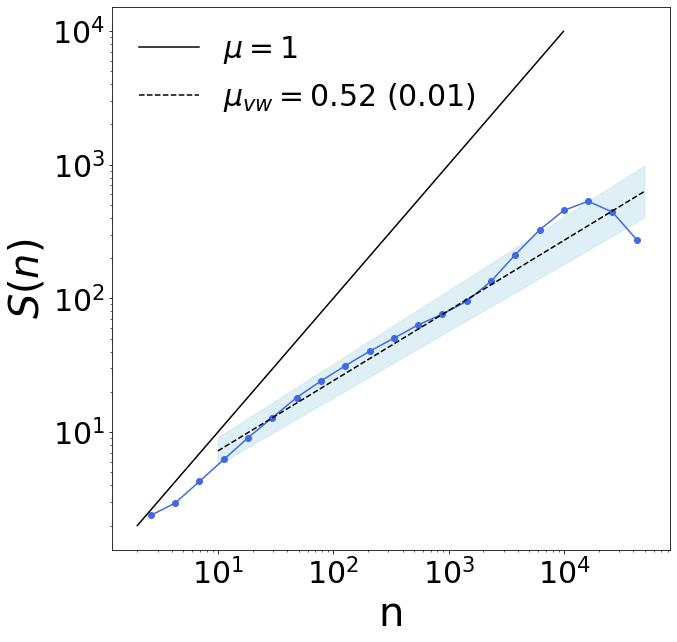

In [8]:
#plt.plot(mm.n, mm.s_n)
fig = plt.figure(figsize=(10,10))

x, y = get_distribution_collection([mm.n, mm.s_n], number_of_bins = 30)

y = y[:-8]
x = x[:-8]

plt.plot(x,y, marker='o', color='royalblue')

plt.plot(range(2, 10000,100), range(2, 10000,100),label=r'$\mu = 1$', color='black')

x_arr = range(10, 50000, 5)
plt.plot(x_arr,[np.exp(np.log(i)*beta_res + c_res) for i in x_arr], color='black',linestyle='--',
         label=r'$\mu_{vw} = $'+ str(round(beta_res,2))+' ('+str(round(beta_se_res, 2))+')')
#             color='black', linestyle='--', alpha = 0.8,label=r'$\beta = $'+ str(round(beta_res,2)) + ", SE = "+str(round(beta_se_res,2)))

y_se_minus_arr = [np.exp(np.log(i)*(beta_res - 1.96*beta_se_res) + (c_res- 1.96*c_se_res)) for i in x_arr]
y_se_plus_arr = [np.exp(np.log(i)*(beta_res+ 1.96*beta_se_res) + (c_res+ 1.96*c_se_res)) for i in x_arr]
plt.fill_between(x_arr, y_se_minus_arr, y_se_plus_arr, alpha = 0.4, color='lightblue')


plt.legend(fontsize=30, frameon=False, loc=2)
plt.tick_params(labelsize=30)
plt.xlabel("n", fontsize=40, labelpad = 5)
plt.ylabel(r"$S(n)$", fontsize=40, labelpad = 5)

plt.loglog()
#plt.savefig("plots/s_n_explored.pdf", bbox_inches='tight')
plt.show()

## 2) P(S*) vs S*

In [43]:
### all the movements resolved to time, 
### --- this resolution is important to capture time spent at each location
traj_movements = pd.read_csv("final-curated-data/time_user_mobility.csv")
traj_movements.columns = ['peer_address','points','date','timesteps']
traj_movements['date'] = traj_movements.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
traj_movements['traj'] = traj_movements.points.apply(lambda x: x.split('|'))
traj_movements.head()

,peer_address,points,date,timesteps,traj
0,0x6e66204c0c21553ea502714da1d1a19e6c7dc729,"-109,135|-109,135|-109,135|-109,135|-109,135|-...",2022-03-15,1647360338|1647360348|1647360358|1647360368|16...,"[-109,135, -109,135, -109,135, -109,135, -109,..."
1,0x40e87f635cd84092009a7e17e4f374d8b9767a25,"-109,135|-109,135|-109,135|-109,135|-109,135|-...",2022-03-15,1647360338|1647360348|1647360358|1647360368|16...,"[-109,135, -109,135, -109,135, -109,135, -109,..."
2,0x56e49b4600df3fd4a22c59d074ea7304093e1240,"-109,135|-109,135|-109,135|-109,135|-109,135|-...",2022-03-15,1647360338|1647360348|1647360358|1647360368|16...,"[-109,135, -109,135, -109,135, -109,135, -109,..."
3,0x7c9c34234fc5527f205d7936847cd7be21479b3a,"-109,135|-109,135|-109,135|-109,135|-109,135|-...",2022-03-15,1647360338|1647360348|1647360358|1647360368|16...,"[-109,135, -109,135, -109,135, -109,135, -109,..."
4,0x6a947822a45923570f99a2c78375aa7ecd6916cd,"-109,135|-109,135|-109,135|-109,135|-109,135|-...",2022-03-15,1647360338|1647360348|1647360358|1647360368|16...,"[-109,135, -109,135, -109,135, -109,135, -109,..."


In [44]:
visitation_freq = traj_movements.explode('traj').groupby('peer_address').traj.value_counts().to_frame()
visitation_freq['peer_address'] = visitation_freq.index.get_level_values(0)
visitation_freq['point'] = visitation_freq.index.get_level_values(1)
visitation_freq.index = range(len(visitation_freq))
visitation_freq.columns = ['n_visits','peer_address','visited_parcel']
visitation_freq.head()

,n_visits,peer_address,visited_parcel
0,8,0x000000000aed5b7afb1f5df81e50fb18801612b1,"8,-1"
1,3,0x000000000aed5b7afb1f5df81e50fb18801612b1,"0,-1"
2,3,0x000000000aed5b7afb1f5df81e50fb18801612b1,"1,0"
3,3,0x000000000aed5b7afb1f5df81e50fb18801612b1,"7,-1"
4,2,0x000000000aed5b7afb1f5df81e50fb18801612b1,"64,22"


In [45]:
total_visits = visitation_freq.groupby('peer_address').n_visits.sum().to_frame()
total_visits['peer_address'] = total_visits.index
total_visits.index = range(len(total_visits))
total_visits.columns = ['total_visits','peer_address']
total_visits.head()

,total_visits,peer_address
0,36,0x000000000aed5b7afb1f5df81e50fb18801612b1
1,29,0x000000ff104866d60ed07d3a5f5be7731777831e
2,12,0x00001b6206cd9190f86f23d4754de2655618f336
3,1433,0x00003c72207a89e4fd16e3db34e3fef7d42a9ae9
4,59,0x00009dc8aac69accf38e87ab42a82a28be68f2a0


In [48]:
visitation_freq = pd.merge(visitation_freq, total_visits, how='left',on='peer_address')
visitation_freq['pr_visits'] = visitation_freq.n_visits/visitation_freq.total_visits
#visitation_freq = visitation_freq[visitation_freq.peer_address.isin(tmp_traj_df.peer_address)]
visitation_freq.head()

,n_visits,peer_address,visited_parcel,total_visits,pr_visits
0,8,0x000000000aed5b7afb1f5df81e50fb18801612b1,"8,-1",36,0.222222
1,3,0x000000000aed5b7afb1f5df81e50fb18801612b1,"0,-1",36,0.083333
2,3,0x000000000aed5b7afb1f5df81e50fb18801612b1,"1,0",36,0.083333
3,3,0x000000000aed5b7afb1f5df81e50fb18801612b1,"7,-1",36,0.083333
4,2,0x000000000aed5b7afb1f5df81e50fb18801612b1,"64,22",36,0.055556


In [49]:
visitation_freq = pd.merge(visitation_freq, n_parc_visited, how='left',on='peer_address')
visitation_freq.head()

,n_visits,peer_address,visited_parcel,total_visits,pr_visits,n_parcel_visited
0,8,0x000000000aed5b7afb1f5df81e50fb18801612b1,"8,-1",36,0.222222,20.0
1,3,0x000000000aed5b7afb1f5df81e50fb18801612b1,"0,-1",36,0.083333,20.0
2,3,0x000000000aed5b7afb1f5df81e50fb18801612b1,"1,0",36,0.083333,20.0
3,3,0x000000000aed5b7afb1f5df81e50fb18801612b1,"7,-1",36,0.083333,20.0
4,2,0x000000000aed5b7afb1f5df81e50fb18801612b1,"64,22",36,0.055556,20.0


In [50]:
visitation_freq = visitation_freq.drop_duplicates()

In [60]:
t = copy.deepcopy(visitation_freq)
t = t.sort_values('visited_parcel',ascending=False)

In [61]:
t2 = (t.groupby('peer_address')
      .agg({'pr_visits': lambda x: x.tolist()}))
t2['peer_address'] = t2.index
t2.index = range(len(t2))
t2.head()

,pr_visits,peer_address
0,"[0.2222222222222222, 0.027777777777777776, 0.0...",0x000000000aed5b7afb1f5df81e50fb18801612b1
1,"[0.034482758620689655, 0.06896551724137931, 0....",0x000000ff104866d60ed07d3a5f5be7731777831e
2,[1.0],0x00001b6206cd9190f86f23d4754de2655618f336
3,"[0.0027913468248429866, 0.0013956734124214933,...",0x00003c72207a89e4fd16e3db34e3fef7d42a9ae9
4,"[0.01694915254237288, 0.01694915254237288, 0.0...",0x00009dc8aac69accf38e87ab42a82a28be68f2a0


In [15]:
pr_all = {}

for u in tqdm(visitation_freq.peer_address.unique()):
    t = visitation_freq[visitation_freq.peer_address == u]
    t = t.sort_values('pr_visits', ascending = False)
    
    for i, j in enumerate(t.pr_visits.tolist()[:100]):
        if i+1 not in pr_all:
            pr_all[i+1] = []
        pr_all[i+1].append(j)

  0%|          | 48/159795 [00:06<5:57:51,  7.44it/s]


KeyboardInterrupt: 

In [52]:
tmp_visit_freq = visitation_freq

pr_visits_10 = {}
for u in tqdm(tmp_visit_freq[tmp_visit_freq.n_parcel_visited==25].peer_address.unique()):
    t = tmp_visit_freq[tmp_visit_freq.peer_address == u]
    t = t.sort_values('pr_visits', ascending = False)
    
    for i, j in enumerate(t.pr_visits.tolist()[:25]):
        if i+1 not in pr_visits_10:
            pr_visits_10[i+1] = []
        pr_visits_10[i+1].append(j)
        
pr_visits_50 = {}

for u in tqdm(tmp_visit_freq[tmp_visit_freq.n_parcel_visited==40].peer_address.unique()):
    t = tmp_visit_freq[tmp_visit_freq.peer_address == u]
    t = t.sort_values('pr_visits', ascending = False)
    
    for i, j in enumerate(t.pr_visits.tolist()[:40]):
        if i+1 not in pr_visits_50:
            pr_visits_50[i+1] = []
        pr_visits_50[i+1].append(j)
    
    
pr_visits_100 = {}

for u in tqdm(tmp_visit_freq[tmp_visit_freq.n_parcel_visited==60].peer_address.unique()):
    t = tmp_visit_freq[tmp_visit_freq.peer_address == u]
    t = t.sort_values('pr_visits', ascending = False)
    
    for i, j in enumerate(t.pr_visits.tolist()[:60]):
        if i+1 not in pr_visits_100:
            pr_visits_100[i+1] = []
        pr_visits_100[i+1].append(j)

pr_visits_200 = {}

for u in tqdm(tmp_visit_freq[tmp_visit_freq.n_parcel_visited==80].peer_address.unique()):
    t = tmp_visit_freq[tmp_visit_freq.peer_address == u]
    t = t.sort_values('pr_visits', ascending = False)
    
    for i, j in enumerate(t.pr_visits.tolist()[:80]):
        if i+1 not in pr_visits_200:
            pr_visits_200[i+1] = []
        pr_visits_200[i+1].append(j)


100%|██████████| 75/75 [00:14<00:00,  5.25it/s]


In [151]:
for j, cc in enumerate([pr_visits_10]):
    mm_counts = []
    mm_err = []
    for i in range(1,len(cc)+1):
        mm_counts.append(np.mean(cc[i]))
        mm_err.append(np.std(cc[i])/np.sqrt(len(cc[i])))
        
    xval = np.arange(1, len(mm_counts)+1)
    mm_counts = np.array(mm_counts)


In [152]:
X = np.log(xval)
X = sm.add_constant(X)
Y = np.log(mm_counts)

model = sm.OLS(Y,X)

res = model.fit()
print(res.params)
print(np.exp(res.params[0]), res.params[1]*-1)

c_res_std, beta_res_std = res.params[0], res.params[1] 
c_se_res_std, beta_se_res_std = res.bse[0], res.bse[1]
print(beta_res_std - 1.96*beta_se_res_std, beta_res_std + 1.96*beta_se_res_std)
print(res.summary())

[-0.84302541 -1.35771004]
0.4304063958754299 1.357710037603299
-1.4174348080624293 -1.2979852671441685
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1985.
Date:                Wed, 01 Nov 2023   Prob (F-statistic):           7.87e-24
Time:                        14:56:56   Log-Likelihood:                 17.647
No. Observations:                  25   AIC:                            -31.29
Df Residuals:                      23   BIC:                            -28.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

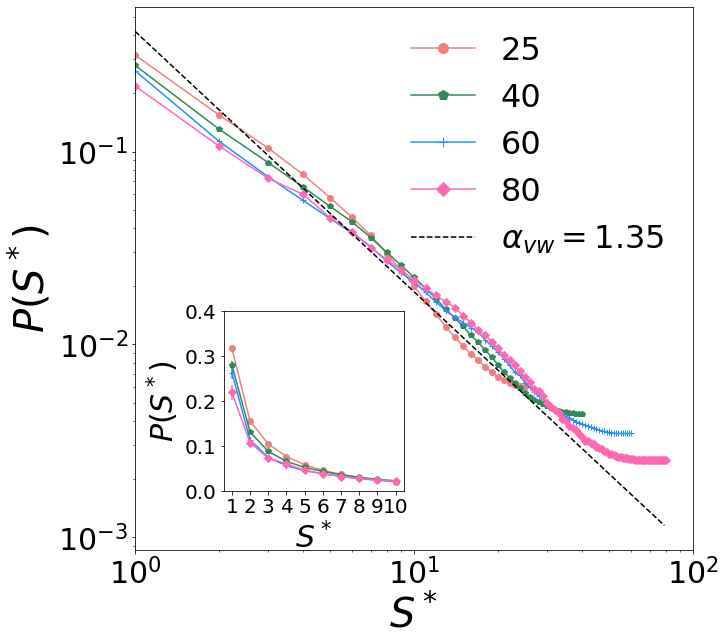

In [59]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()

leg_labels = ['25', '40','60','80']
colors_l = ['lightcoral','seagreen','dodgerblue','hotpink']
markers_l = ['o','p','+','D']

for j, cc in enumerate([pr_visits_10, pr_visits_50,pr_visits_100,pr_visits_200]):
    mm_counts = []
    mm_err = []
    for i in range(1,len(cc)+1):
        mm_counts.append(np.mean(cc[i]))
        mm_err.append(np.std(cc[i])/np.sqrt(len(cc[i])))
        
    xval = np.arange(1, len(mm_counts)+1)
    mm_counts = np.array(mm_counts)
    plt.plot(xval, mm_counts, marker=markers_l[j], color=colors_l[j],label=leg_labels[j])
    
    #x, y = rescale_powerlaw_with_cutoff(xval, mm_counts, 0.01)    
    #plt.plot(x,y, marker=markers_l[j], color=colors_l[j], label = leg_labels[j])
    
## fit 
popt = [0.42, 1.35]
xval = np.arange(1, 80)
yval_res = power_law_fit(xval, *popt)    
plt.plot(xval, yval_res, linestyle='--', color='black', label = r'$\alpha_{vw} = 1.35$')

plt.tick_params(labelsize=30)
plt.loglog()
plt.xlabel(r"$S^*$", fontsize=40, labelpad=5)
plt.ylabel("$P(S^*)$", fontsize=40, labelpad = 5)
plt.xlim(1,100)
lgnd = plt.legend(fontsize=32, frameon=False, markerscale=5)

#change the marker size manually for both lines
for lh in lgnd.legendHandles:
    lh._legmarker.set_markersize(10)

## inset plot
ax_ins = inset_axes(ax,width=2.5, # width = 30% of parent_bbox
                    height=2.5, # height : 1 inch
                    loc=3, bbox_to_anchor=(0.15,0.1,0.95,0.9), bbox_transform=ax.transAxes)



for j, cc in enumerate([pr_visits_10, pr_visits_50,pr_visits_100,pr_visits_200]):
    mm_counts = []
    mm_err = []
    for i in range(1,11):
        mm_counts.append(np.mean(cc[i]))
        mm_err.append(np.std(cc[i])/np.sqrt(len(cc[i])))
    
#    for i in range(4):
#        mm_val_overall[i].append(mm_counts[i])
    
    xval = np.arange(1, len(mm_counts)+1)
    ax_ins.errorbar(xval, mm_counts, mm_err,
                    label=leg_labels[j], color=colors_l[j], marker=markers_l[j])

#ax_ins.loglog()

ax_ins.tick_params(labelsize=20)
ax_ins.set_xticks(range(1,11))
#ax_ins.set_xlim(1,100)
ax_ins.set_ylim(0, 0.4)

ax_ins.set_ylabel(r"$P(S^*)$", fontsize=30)
ax_ins.set_xlabel(r"$S^*$", fontsize=30)

#plt.savefig("plots/prefered_k_dist.pdf", bbox_inches='tight')
plt.show()

## 3) dispersion of visitation

In [60]:
### variance vs mean
std_df = visitation_freq.groupby('peer_address').n_visits.std().to_frame()
std_df['peer_address'] = std_df.index
std_df.index = range(len(std_df))
std_df.columns = ['std_l','peer_address']
std_df.head()

,std_l,peer_address
0,1.641565,0x000000000aed5b7afb1f5df81e50fb18801612b1
1,2.314946,0x000000ff104866d60ed07d3a5f5be7731777831e
2,NaN,0x00001b6206cd9190f86f23d4754de2655618f336
3,142.248341,0x00003c72207a89e4fd16e3db34e3fef7d42a9ae9
4,4.392702,0x00009dc8aac69accf38e87ab42a82a28be68f2a0


In [61]:
visitation_freq['mean_visits'] = visitation_freq.total_visits/visitation_freq.n_parcel_visited

In [62]:
std_df = pd.merge(std_df, visitation_freq[['peer_address','mean_visits']].drop_duplicates(), how='left',on='peer_address')
std_df.head()

,std_l,peer_address,mean_visits
0,1.641565,0x000000000aed5b7afb1f5df81e50fb18801612b1,1.800000
1,2.314946,0x000000ff104866d60ed07d3a5f5be7731777831e,2.230769
2,NaN,0x00001b6206cd9190f86f23d4754de2655618f336,NaN
3,142.248341,0x00003c72207a89e4fd16e3db34e3fef7d42a9ae9,75.421053
4,4.392702,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,4.916667


In [63]:
std_df = std_df[(std_df.std_l>=1)&(std_df.mean_visits>=1)]

In [64]:
#Y = np.log(std_df[std_df.std_l>0].mean_visits)
#X = np.log(std_df[std_df.std_l>0].std_l)

X = np.log(np.array(std_df.mean_visits))
Y = np.log(np.array(std_df.std_l))
X = sm.add_constant(X)

model = sm.OLS(Y,X)

res = model.fit()
print(res.params)

c_res_std, beta_res_std = res.params[0], res.params[1] 
c_se_res_std, beta_se_res_std = res.bse[0], res.bse[1]
print(beta_res_std - 1.96*beta_se_res_std, beta_res_std + 1.96*beta_se_res_std)
print(res.summary())

[-0.03005123  1.09950179]
1.0979886956446756 1.1010148771250732
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 2.028e+06
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        17:18:58   Log-Likelihood:                -93150.
No. Observations:              131415   AIC:                         1.863e+05
Df Residuals:                  131413   BIC:                         1.863e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

if you are more frequent you tend to diversify your exploration


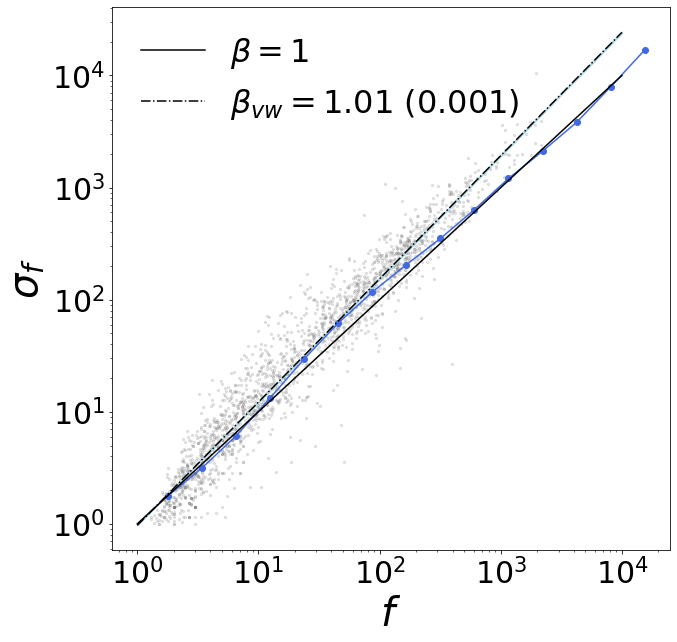

In [70]:
plt.figure(figsize=(10,10))
    
tmp_std_df = std_df.sample(2000)
plt.scatter(tmp_std_df.mean_visits, tmp_std_df.std_l, alpha = 0.2, s = 5, color='gray')

x, y = get_distribution_collection((std_df.mean_visits.tolist(), std_df.std_l.tolist()), 
                                   number_of_bins = 20, avg = True)
x = x[:-4]
y = y[:-4]
plt.plot(x,y, marker='o', color='royalblue')

plt.plot(range(1,10000), range(1,10000), color='black',label=r'$\beta=1$',  linestyle='-')

x_arr = range(1, 10000)
plt.plot(x_arr,[np.exp(np.log(i)*beta_res_std + c_res_std) for i in x_arr], color='black', 
         linestyle='-.', label=r'$\beta_{vw} = 1.01$ '+ '(0.001)')

y_se_minus_arr = [np.exp(np.log(i)*(beta_res_std - 1.96*beta_se_res_std) + (c_res_std- 1.96*c_se_res_std)) for i in x_arr]
y_se_plus_arr = [np.exp(np.log(i)*(beta_res_std+ 1.96*beta_se_res_std) + (c_res_std + 1.96*c_se_res_std)) for i in x_arr]

plt.fill_between(x_arr, y_se_minus_arr, y_se_plus_arr, alpha = 1, color='lightblue')

#plt.fill_between(x_arr, y_se_minus_arr, y_se_plus_arr, alpha = 0.1, color='red')

plt.xlabel(r"$f$", fontsize = 40, labelpad=5)
plt.ylabel(r"$\sigma_{f}$", fontsize = 40, labelpad=5)

plt.tick_params(labelsize= 30)
plt.loglog()
plt.legend(fontsize = 32, frameon=False, loc=2)
#plt.savefig("plots/dispersion_exploration.pdf", bbox_inches='tight')
print("if you are more frequent you tend to diversify your exploration")
plt.show()

## 4) Prob of visitation to a location

In [6]:
traj_s_df = traj_df.sort_values('date')[['peer_address','traj']].explode('traj')
traj_s_df.head()

,peer_address,traj
0,0x6e66204c0c21553ea502714da1d1a19e6c7dc729,"-109,135"
0,0x6e66204c0c21553ea502714da1d1a19e6c7dc729,"-109,136"
0,0x6e66204c0c21553ea502714da1d1a19e6c7dc729,"-107,133"
0,0x6e66204c0c21553ea502714da1d1a19e6c7dc729,"-107,134"
0,0x6e66204c0c21553ea502714da1d1a19e6c7dc729,"-109,134"


In [7]:
n_obs = traj_s_df.groupby('peer_address').traj.nunique().to_frame()
n_obs['p_address'] = n_obs.index
n_obs.index = range(len(n_obs))
n_obs.columns = ['n_obs','peer_address']
n_obs.head()

,n_obs,peer_address
0,20,0x000000000aed5b7afb1f5df81e50fb18801612b1
1,13,0x000000ff104866d60ed07d3a5f5be7731777831e
2,19,0x00003c72207a89e4fd16e3db34e3fef7d42a9ae9
3,12,0x00009dc8aac69accf38e87ab42a82a28be68f2a0
4,15,0x0000baa55a9c2a06a3922c563d8d9fcb1a0dbf2f


In [10]:
def get_user_dsdn(u):
    n_seen = []
    pr_new = []
    peer_address = []

    
    t = traj_s_df[traj_s_df.peer_address == u]
    
    curr_loc = t.iloc[0]['traj']
    all_locs = [t.iloc[0]['traj']]
    
    for _, j in enumerate(t.traj.tolist()[1:]):
        if j == curr_loc:
            continue

        if len(all_locs)> 100:
            break

        if j in all_locs:
            n_seen.append(len(all_locs))
            pr_new.append(0)
        else:
            n_seen.append(len(all_locs))
            pr_new.append(1)
            ## add the loc
            all_locs.append(j)
                
        curr_loc = j
        peer_address.append(u)
        
    return pd.DataFrame({"origin_acc":peer_address,'n':n_seen,'pr_new':pr_new})

In [40]:
ds_dn_df = pd.DataFrame()

for u in tqdm(np.random.choice(n_obs[n_obs.n_obs<300].peer_address.tolist(), 140000)):
    ds_dn_df = ds_dn_df.append(get_user_dsdn(u))
ds_dn_df = ds_dn_df.drop_duplicates()
ds_dn_df.head()

  0%|          | 281/140000 [03:44<30:56:25,  1.25it/s]


KeyboardInterrupt: 

In [37]:
tt = ds_dn_df.groupby('n').pr_new.mean().to_frame()
tt['n'] = tt.index

X = np.log(np.array(tt.n))
Y = np.log(np.array(tt.pr_new))
X = sm.add_constant(X)

model = sm.OLS(Y,X)

res = model.fit()
print(np.exp(res.params[0]), res.params[1])

c_res_std, beta_res_std = res.params[0], res.params[1] 
c_se_res_std, beta_se_res_std = res.bse[0], res.bse[1]
#print(beta_res_std - 1.96*beta_se_res_std, beta_res_std + 1.96*beta_se_res_std)
print(res.summary())

0.37636140191887235 -0.22925056270711153
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     9.397
Date:                Tue, 23 Jan 2024   Prob (F-statistic):            0.00281
Time:                        09:42:10   Log-Likelihood:                -103.86
No. Observations:                 100   AIC:                             211.7
Df Residuals:                      98   BIC:                             216.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

In [38]:
tt_std = ds_dn_df.groupby('n').pr_new.mean().to_frame()
tt_std['n'] = tt_std.index
tt_std.index = range(len(tt_std))
tt_std.columns = ['std_val','n']

tt_n = ds_dn_df.n.value_counts().to_frame()
tt_n['nn'] = tt_n.index
tt_n.index = range(len(tt_n))
tt_n.columns = ['nn','n']

tt_std = pd.merge(tt_std, tt_n, how='left',on='n')
tt_std['stde_val'] = tt_std.std_val/tt_std.nn

tt = ds_dn_df.groupby('n').pr_new.mean().to_frame()
tt['n'] = tt.index
tt.columns = ['pr_new','n']
tt.index = range(len(tt))
tt = pd.merge(tt, tt_std, how='left', on='n')
tt.head()

,pr_new,n,std_val,nn,stde_val
0,1.000000,1,1.000000,998,0.001002
1,0.814480,2,0.814480,1105,0.000737
2,0.738544,3,0.738544,1113,0.000664
3,0.714147,4,0.714147,1032,0.000692
4,0.711111,5,0.711111,945,0.000752


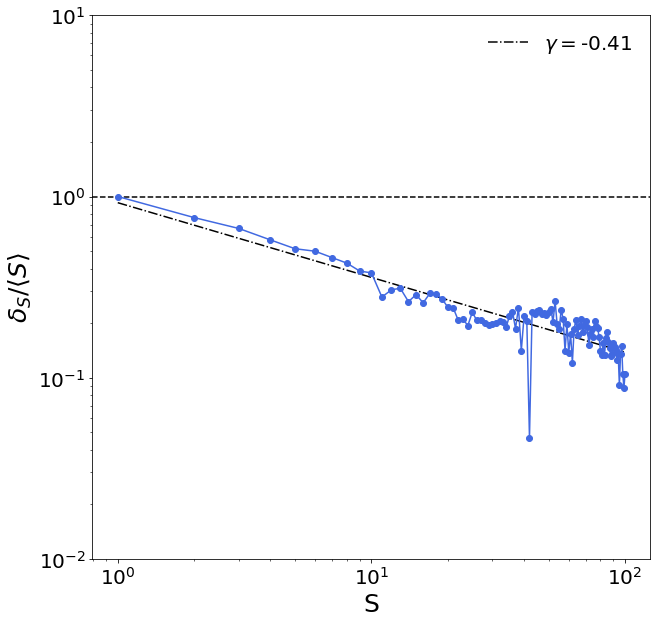

In [173]:
fig = plt.figure(figsize=(10,10))
#plt.plot(tt.n, tt.pr_new, marker='o')

plt.errorbar(tt.n, tt.pr_new, yerr = tt.stde_val, 
             color='royalblue', marker='o')

x_arr = range(1, 100)
plt.plot(x_arr,[np.exp(np.log(i)*(beta_res_std) + c_res_std) for i in x_arr], 
         color='black', 
         linestyle='-.', label=r'$\gamma = $'+str(round(beta_res_std,2)))

plt.axhline(y=1, linestyle='--', color='black')

plt.loglog()
#plt.xlim(0,55)
plt.tick_params(labelsize=20)
plt.xlabel("S", fontsize=25)
plt.ylabel(r"$\delta_S/\langle S \rangle$", fontsize=25)
plt.legend(fontsize=20, frameon=False)

plt.ylim(0.01, 10)
#plt.savefig('plots/si/delta_s_n.pdf', bbox_inches='tight')
plt.show()

## Collective mobility

In [5]:
### load the graph
g = nx.Graph(weighted = True)

for i in tqdm(range(len(traj_df))):    
    t_l = traj_df.iloc[i]['traj']
    u_l = traj_df.iloc[i]['peer_address']
    prev_ctr = t_l[0]

    for ii in t_l[1:]:
        if ii != prev_ctr:                
            if not g.has_edge(ii, prev_ctr):
                g.add_edge(ii, prev_ctr, weight = 0)
                #g[ii][prev_ctr]['users'] = []
            
            g[ii][prev_ctr]['weight'] +=1
            #if u_l not in g[ii][prev_ctr]['users']:
            #    g[ii][prev_ctr]['users'].append(u_l)

print(nx.info(g))

100%|██████████| 603215/603215 [01:48<00:00, 5575.43it/s]


Name: 
Type: Graph
Number of nodes: 69433
Number of edges: 618358
Average degree:  17.8116


## 1) P(k) $\propto$ to $k^{-\alpha}$

Calculating best minimal value for power law fit
0.006508406451839337
1.9784063845368294


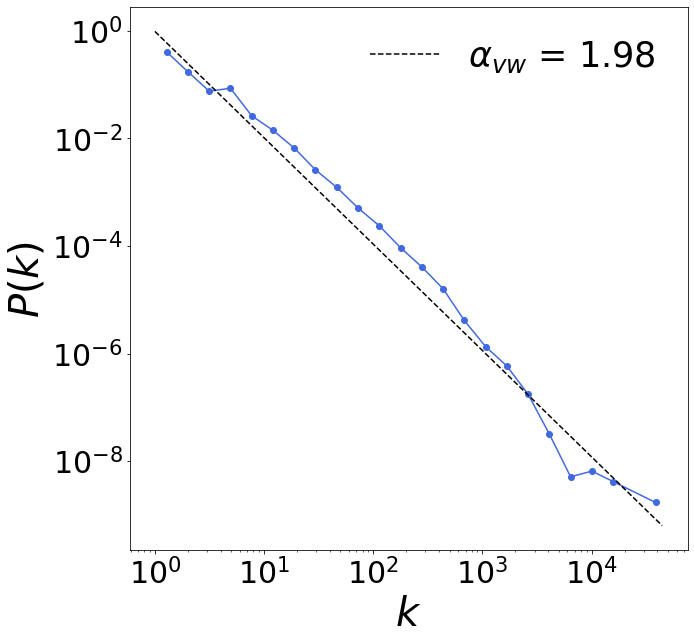

In [7]:
fig = plt.figure(figsize=(10,10))

l = list(dict(g.degree()).values())
x, y= get_distribution(l, density = True, number_of_bins = 30)

plt.plot(x,y, marker='o', color='royalblue')

fit = powerlaw.Fit(l)
alpha = fit.power_law.alpha
print(fit.power_law.sigma)
print(alpha)

x = np.arange(1, np.max(l))
# find the powerlaw fit line
ypowerlaw_fit = (alpha - 1)*min(x)**((alpha - 1))*x**(-alpha)

plt.plot(x, ypowerlaw_fit,linestyle='--', 
        color='black',alpha =1,
         label = r'$\alpha_{vw}$ = '+str(round(alpha,2)))

plt.loglog()
plt.tick_params(labelsize=30)
plt.xlabel(r"$k$", fontsize=40, labelpad = 5)
plt.ylabel(r"$P(k)$", fontsize=40, labelpad = 5)
plt.legend(fontsize=35, frameon=False)

#plt.savefig("plots/si/pk_dist_lands.pdf", bbox_inches='tight')
plt.show()

## 2) $P(w_{ij}) \propto w_{ij}^{-\alpha}$

In [10]:
ori_pop = []
des_pop = []
ori_deg = []
des_deg = []

flux_emp = []
#flux_users_emp = []

ori  = []
des = []
dis = []

for r in g.edges(data = True):
    l1, l2 = r[0], r[1]
    w = r[2]['weight']
    
    ori_pop.append(pop_df_dict[l1])
    des_pop.append(pop_df_dict[l2])
    
    ori_deg.append(g.degree(l1))
    des_deg.append(g.degree(l2))
    
    ori.append(l1)
    des.append(l2)
    flux_emp.append(w)
    #flux_users_emp.append(len(r[2]['users']))
    dis.append(abs(int(l1.split(',')[0]) - int(l2.split(',')[0])) + abs(int(l1.split(',')[1]) - int(l2.split(',')[1])))

flux_df = pd.DataFrame({"ori":ori,'des':des,'flux':flux_emp,
                        #'flux_users':flux_users_emp,
                        'ori_pop':ori_pop,'des_pop':des_pop,
                        'ori_deg':ori_deg,'des_deg':des_deg,
                       'dis':dis})

flux_df.head()

,ori,des,flux,ori_pop,des_pop,ori_deg,des_deg,dis
0,"-109,136","-109,135",677,1329,20143,101,1047,1
1,"-109,136","-107,133",466,1329,25171,101,1597,5
2,"-109,136","-75,76",46,1329,24181,101,2146,94
3,"-109,136","-107,135",292,1329,20620,101,1266,3
4,"-109,136","-109,133",306,1329,20218,101,1283,3


Calculating best minimal value for power law fit
2.175518445818324%
0.08689682395483656


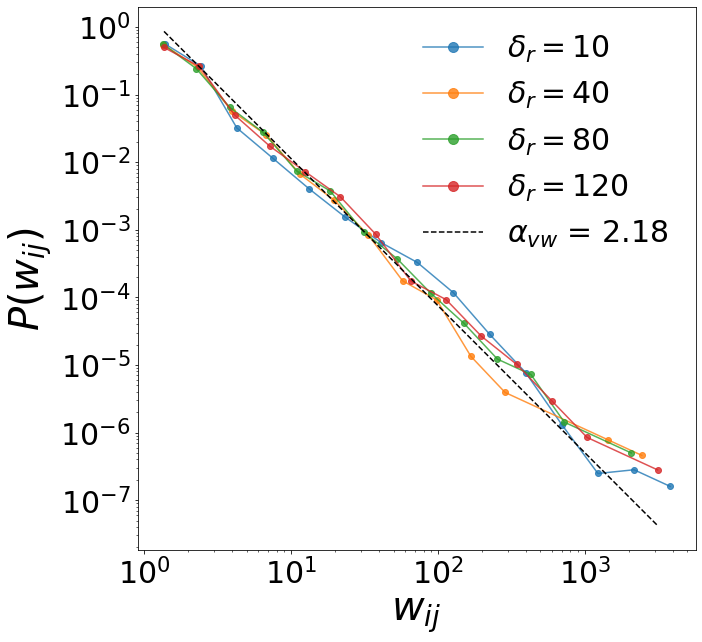

In [14]:
fig = plt.figure(figsize=(10,10))

#plt.scatter(flux_df.dis, flux_df.flux, alpha = 0.1, color='gray')


for i in [10, 40, 80, 120]:
    x, y = get_distribution(flux_df[flux_df.dis == i].flux.tolist(), density = True)
    plt.plot(x,y, marker='o', alpha = 0.8, label = r'$\delta_r=$'+str(i))

    
fit = powerlaw.Fit(flux_df[flux_df.dis == 80].flux.tolist())
alpha = fit.power_law.alpha
print(alpha)
print(fit.power_law.sigma)
#alpha = float(1.9513648172666604)
    
# find the powerlaw fit line
ypowerlaw_fit = (alpha - 1)*min(x)**((alpha - 1))*x**(-alpha)

plt.plot(x, ypowerlaw_fit,linestyle='--', 
        color='black',alpha =1,
         label = r'$\alpha_{vw}$ = '+str(round(alpha,2)))

lgnd = plt.legend(fontsize=30, frameon=False, markerscale=5, loc=1)

#change the marker size manually for both lines
for lh in lgnd.legendHandles:
    lh._legmarker.set_markersize(10)

plt.loglog()

plt.tick_params(labelsize=30)
plt.xlabel(r"$w_{ij}$", fontsize=40, labelpad = 5)
plt.ylabel(r"$P(w_{ij})$", fontsize=40, labelpad = 5)

#plt.savefig('plots/si/wij_distance_mobility.pdf', bbox_inches='tight')
plt.show()

## 3) N(s) $\propto k^{\beta}$

In [17]:
t = flux_df[['des','des_pop','des_deg']].drop_duplicates()

X = np.log(np.array(t.des_deg))
Y = np.log(np.array(t.des_pop))
X = sm.add_constant(X)

model = sm.OLS(Y,X)

res = model.fit()
print(res.params)

c_res_std, beta_res_std = res.params[0], res.params[1] 
c_se_res_std, beta_se_res_std = res.bse[0], res.bse[1]
print(beta_res_std - 1.96*beta_se_res_std, beta_res_std + 1.96*beta_se_res_std)
print(res.summary())

[0.13097936 1.04929294]
1.0462331212281812 1.0523527576484684
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                 4.518e+05
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        19:58:17   Log-Likelihood:                -54471.
No. Observations:               69360   AIC:                         1.089e+05
Df Residuals:                   69358   BIC:                         1.090e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

362


/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


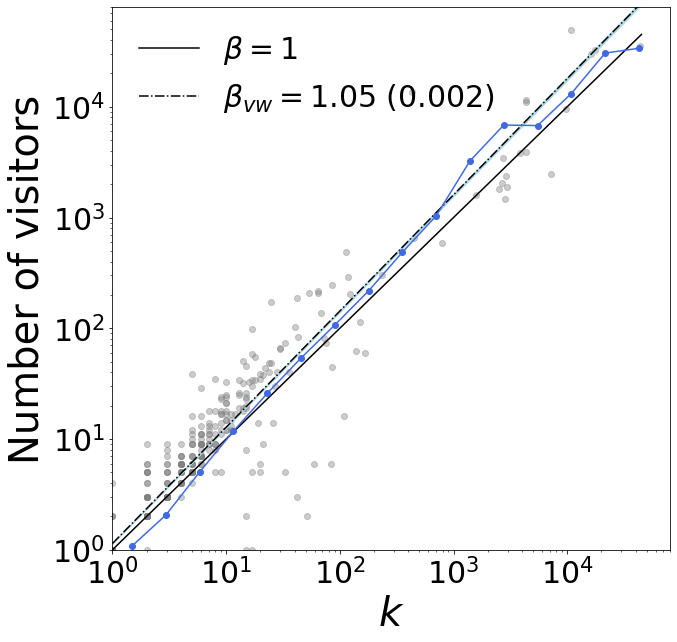

In [31]:
t = flux_df[['des','des_pop','des_deg']].drop_duplicates()

fig = plt.figure(figsize=(10,10))

u = np.linspace(1, t.des_deg.max(), 20)
xs = []
ys = []

for i, j in enumerate(u):
    if i == 0:
        continue
    
    u_t = t[(t.des_deg>=u[i-1])&(t.des_deg<j)]
    
    if len(u_t)>=50:
        u_t = u_t.sample(int(len(u_t)*0.005))
    
    xs.extend(u_t.des_deg.tolist())
    ys.extend(u_t.des_pop.tolist())
print(len(xs))    
plt.scatter(xs, ys, alpha = 0.4, color='gray')

#plt.scatter(t2.des_deg, t2.des_pop, alpha = 0.1, color='gray')

plt.plot(range(1,45000), range(1, 45000), label = r'$\beta = 1$', color='black')
x_arr = range(1, 45000,100)
plt.plot(x_arr,[np.exp(np.log(i)*(beta_res_std) + c_res_std) for i in x_arr], 
         color='black', 
         linestyle='-.', label=r'$\beta_{vw} = 1.05$'+' (0.002)')

y_se_minus_arr = [np.exp(np.log(i)*(beta_res_std - 1.96*beta_se_res_std) + (c_res_std- 1.96*c_se_res_std)) for i in x_arr]
y_se_plus_arr = [np.exp(np.log(i)*(beta_res_std+ 1.96*beta_se_res_std) + (c_res_std + 1.96*c_se_res_std)) for i in x_arr]

plt.fill_between(x_arr, y_se_minus_arr, y_se_plus_arr, alpha = 1, color='lightblue')

#plt.plot(range(1,100000,100), range(1,100000, 100), color='black', label=r'$\beta = 1$')

x, y = get_distribution_collection([t.des_deg, t.des_pop], number_of_bins = 20)

x = x[:-3]
y = y[:-3]
plt.plot(x,y, marker='o', color='royalblue')

plt.xlim(0.99,80000)
plt.ylim(0.99,80000)
plt.legend(fontsize=30, frameon=False)
plt.loglog()
plt.tick_params(labelsize=30)
plt.xlabel(r"$k$", fontsize=40, labelpad = 5)
plt.ylabel("Number of visitors", fontsize=40, labelpad = 5)

#plt.savefig('plots/mobility_deg_n_visitors.pdf', bbox_inches='tight')
plt.show()